### N26 Case Study
Author: Garret O'Connell

### The Data Set
The data describes how TV spending and different marketing channels contribute to user acquisition, using the following variables:

* user id
* interaction with marketing channels: 1) cpc 2) organic 3) affiliate 4) social
* signup date
* dates of active TV spending

### Tasks
1. Give an overview of our channels and how they contribute to user acquisition.
2. Estimate the impact of doubling TV spending
3. Make appropriate assumptions for the channel touchpoint cost. With your assumptions give recommendations how to change the budget allocation to maximize user acquisition with a constant budget

### Approach
For task #1 I used a bar chart and a summary table to provide an overview of each channel's contribution to user acquisition by representing both the total number of signups coming from each channel, and the proportion that were on active TV spending days.

For task #2 I modelled the effect of tv spending on increasing the number of signups. To do this I estimated the increase in signups on active vs. non-active tv spending days using simple linear regression.

For task #3 approach and solution see presentation slides.

In [1]:
 # set paths
import os
import pandas as pd
import numpy as np

# import data
path = os.getcwd()
df_tv = pd.read_csv(os.path.join(path,'tv_campaigns.csv'), index_col = False) 
df_user = pd.read_csv(os.path.join(path,'user_signup_data.csv'), index_col = False)

In [2]:
# separate signups depending on dates of active tv spending or not
df_tvdate = df_user.loc[df_user['signup_date'].isin(df_tv['date'])]
df_notvdate = df_user.loc[~df_user['signup_date'].isin(df_tv['date'])]

# count user signups in each channel on active and inactive spending dates
df_tvdate = pd.melt(df_tvdate[['cpc','organic','affiliate','social']], var_name="channel", value_name="active").groupby(['channel']).sum().reset_index()
df_notvdate = pd.melt(df_notvdate[['cpc','organic','affiliate','social']], var_name="channel", value_name="inactive").groupby(['channel']).sum().reset_index()

# merge new tables of active and inactive tv dates and create total column for plotting
df_alltv = pd.merge(df_tvdate, df_notvdate,  how='left', on='channel')
df_alltv['total'] = df_alltv[['active','inactive']].sum(axis=1)

,channel,active,inactive,total,active %
0,affiliate,421,3476,3897,10.803182
1,cpc,191,1467,1658,11.519903
2,organic,59,460,519,11.368015
3,social,323,2662,2985,10.820771


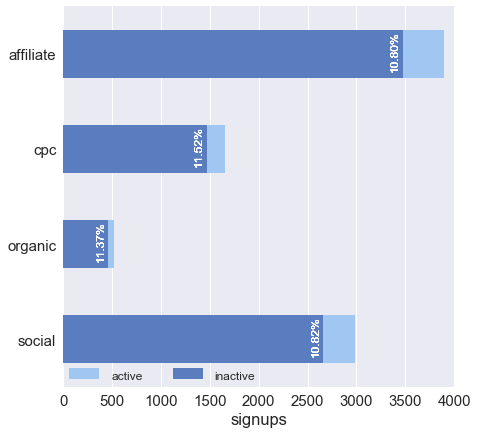

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

# plot style
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x=df_alltv["total"], y=df_alltv["channel"],
            label="active", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
barplot = sns.barplot(x=df_alltv["inactive"], y=df_alltv["channel"],
            label="inactive", color="b");


# Add a legend and informative axis label
ax.legend(ncol=2, loc=(0,0), frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
ax.set(xlim=(0, (df_alltv.total.max().max())+100), ylabel="",
       xlabel="signups")
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
sns.despine(left=True, bottom=True)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .5)

# summary table
df_alltv['active %'] = df_alltv['active']/df_alltv['total']*100

def annotateBars(row, ax=ax): 
       for counter,p in enumerate(ax.patches): 
            if counter >= (len(ax.patches)/2):
                ax.annotate("%.2f%%" % df_alltv['active %'][(counter-4)], ((p.get_x() + p.get_width()-80), p.get_y()+p.get_height()*.85),
                ha='center', va='center', fontsize=12, color='white', rotation=90, xytext=(0, 20),
                textcoords='offset points') 
            else:
                continue
                
plot = df_alltv.apply(annotateBars, ax=ax, axis=0);

fig = barplot.get_figure()
fig.savefig("output.png") 

df_alltv

### 1. Overview of channels
The figure and table above show that the affiliate channel contributes most to user signups, followed by social, then cpc, and organic the least. The percentage of signups from all channels were comparable at 10-11%.

In [4]:
# add column indicating whether data was active for tv spending
df_user['tv'] = df_user['signup_date'].isin(df_tv['date']).astype(int)

In [83]:
# count signups per date for modelling effect of active tv spending
df_dates = df_user.groupby(['signup_date', 'tv']).size().reset_index(name='signups')
df_dates_channels = df_user.groupby(['signup_date'])['cpc','organic','affiliate','social'].sum()
df_dates_all = pd.merge(df_dates, df_dates_channels,  how='left', on='signup_date')

Model slope:     15.1355421686747
Model intercept: 53.614457831325296


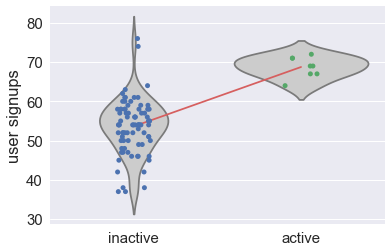

In [161]:
# fit linear regression model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as pyplot

model = LinearRegression(fit_intercept=True)

y = np.array(df_dates['signups'])
x = np.array(df_dates['tv'])

model.fit(x.reshape(-1, 1), y)

xfit = np.linspace(0, 1)
yfit = model.predict(xfit[:, np.newaxis])

df_dates.groupby(['tv']).mean().plot(legend=False, color="r")
ax = sns.violinplot(x=x, y=y, inner=None, color=".8")
ax = sns.stripplot(x=x, y=y, jitter=True, )

ax.set(ylabel='user signups',xlabel='')
ax.set_xticklabels(['inactive','active'], fontsize=15)

fig = ax.get_figure()
fig.savefig("output2.png")

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

In [86]:
# fit linear regression model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as pyplot

model = LinearRegression(fit_intercept=True)

y = np.array(df_dates_all['signups'])
x = np.array(df_dates_all.drop(['signups','signup_date'], axis=1, inplace=False))

model.fit(x, y)
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     1.5369966553794634
Model intercept: 4.682665459299976


### 2. Effect of doubling TV spending
The linear regression model indicated that active TV spending increased user signups to 68.75 per day (model slope) - a 28.28% increase per day compared to the 53.61 signups on inactive days (model intercept). Assuming the relationship between tv spending and user signups increases linearly, and keeping the number of TV spending days constant, this suggests that doubling TV spending days should increase signups by 56.56% (30.28 signups) on active TV spending days (8 days total), resulting in an increase in total user signups from 5000 to 5121. 